In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")
print(df['Has_Shift'].value_counts())

Has_Shift
1    621
0    365
Name: count, dtype: int64


In [4]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['processed_image_path']
        label = self.df.iloc[idx]['Has_Shift']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2,
                                     stratify=df['Has_Shift'],
                                     random_state=42)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
class_counts = df['Has_Shift'].value_counts().to_dict()
class_weights = {label: 1.0 / count for label, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_df['Has_Shift']]
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)


In [8]:
train_dataset = BrainDataset(train_df, transform=train_transform)
test_dataset = BrainDataset(test_df, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 1)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/yaswanth/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:05<00:00, 18.1MB/s]


In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [11]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f}")

Epoch [1/15]  Loss: 0.6642
Epoch [2/15]  Loss: 0.5246
Epoch [3/15]  Loss: 0.3754
Epoch [4/15]  Loss: 0.3453
Epoch [5/15]  Loss: 0.2627
Epoch [6/15]  Loss: 0.2189
Epoch [7/15]  Loss: 0.1929
Epoch [8/15]  Loss: 0.1145
Epoch [9/15]  Loss: 0.0709
Epoch [10/15]  Loss: 0.0915
Epoch [11/15]  Loss: 0.0730
Epoch [12/15]  Loss: 0.0566
Epoch [13/15]  Loss: 0.0673
Epoch [14/15]  Loss: 0.0556
Epoch [15/15]  Loss: 0.0468


In [12]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = [int(x) for x in y_true]
y_pred = [int(x) for x in y_pred]

/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_25260/3321058406.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_25260/3321058406.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x) for x in y_pred]



=== Evaluation Results (ResNet-50) ===
Accuracy : 0.8434
Precision: 0.8507
Recall   : 0.9120
F1 Score : 0.8803

Classification Report:

              precision    recall  f1-score   support

    No Shift       0.83      0.73      0.77        73
       Shift       0.85      0.91      0.88       125

    accuracy                           0.84       198
   macro avg       0.84      0.82      0.83       198
weighted avg       0.84      0.84      0.84       198



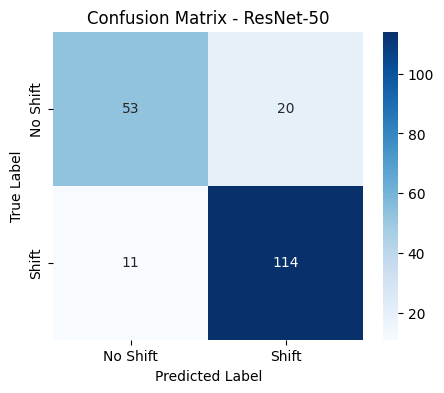

In [13]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n=== Evaluation Results (ResNet-50) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Shift", "Shift"]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Shift", "Shift"],
            yticklabels=["No Shift", "Shift"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet-50")
plt.show()

In [14]:
torch.save(model.state_dict(), "midlineshift_presence_resnet50.pth")